## San Francisco Crime Modeling

Go here for the [details](https://www.kaggle.com/c/sf-crime) on the Kaggle competition

### Predictive Goal:  "Given time and location, you must predict the category of crime that occurred."

Data profiling contained in a separate notebook ("SanFranCrime.ipynb")

### Load the dataset from the prepared Parquet file

In [1]:
parqFileName = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/train.pqt'
sfc_train = spark.read.parquet(parqFileName)
print("Rows in dataset: {:,}".format(sfc_train.count()))
sfc_train.printSchema()


Rows in dataset: 878,049
root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: float (nullable = true)
 |-- Y: float (nullable = true)



In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set()
pdf = sfc_train.select("Category").groupBy("Category").count().orderBy("count", ascending=False).limit(10)

# Visualizing the Data

### Graphically depicting the data at the onset of analysis can help reveal some interesting relationships that may influence modeling choices.

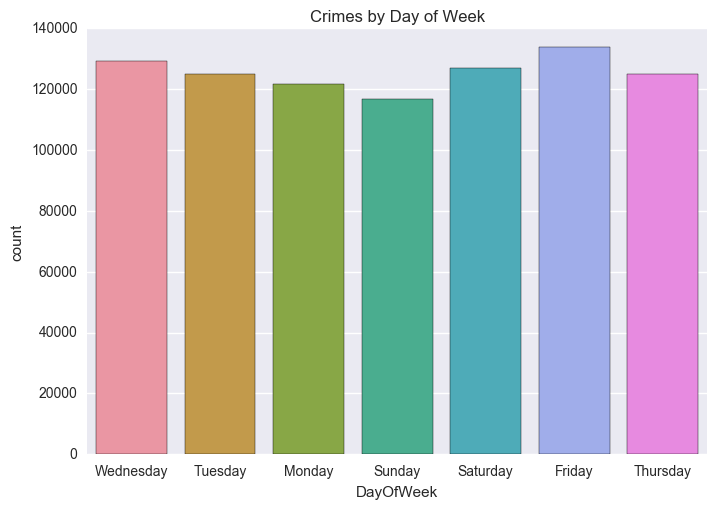

In [3]:
ax = sns.countplot(x="DayOfWeek", data=sfc_train.toPandas())
ax.set(title="Crimes by Day of Week")
sns.plt.show()
# this turns out to not be very interesting

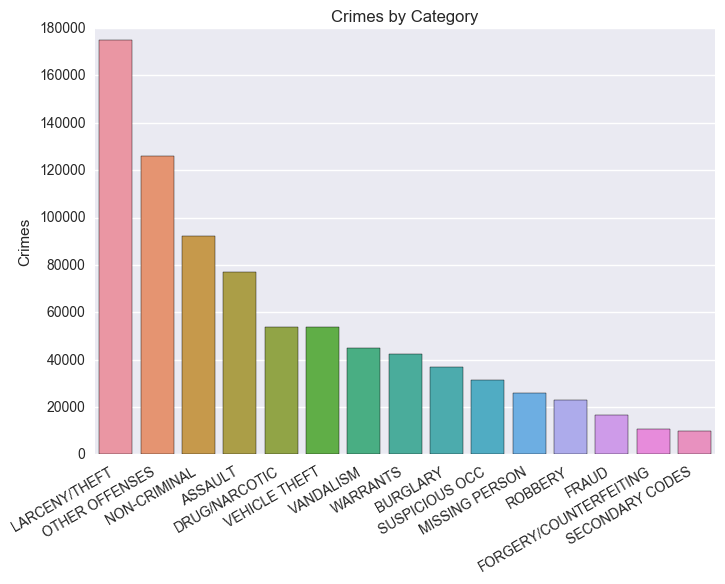

In [4]:
pdf = sfc_train.select("Category").groupBy("Category").count().orderBy("count", ascending=False).limit(15)
ax = sns.barplot(x="Category", y="count", data=pdf.toPandas())
for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
ax.set(xlabel="", ylabel="Crimes", title="Crimes by Category")
sns.plt.show()
# Clearly, Larceny/Theft dominates other categories

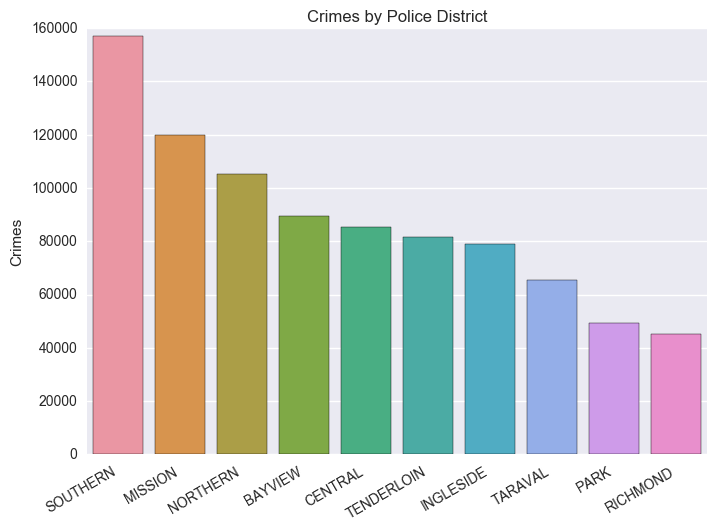

In [5]:
pdf = sfc_train.select("PdDistrict").groupBy("PdDistrict").count().orderBy("count", ascending=False)
ax = sns.barplot(x="PdDistrict", y="count", data=pdf.toPandas())
for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
ax.set(xlabel="", ylabel="Crimes", title="Crimes by Police District")
sns.plt.show()
# Southern is the leader, followed close by Mission and Northern

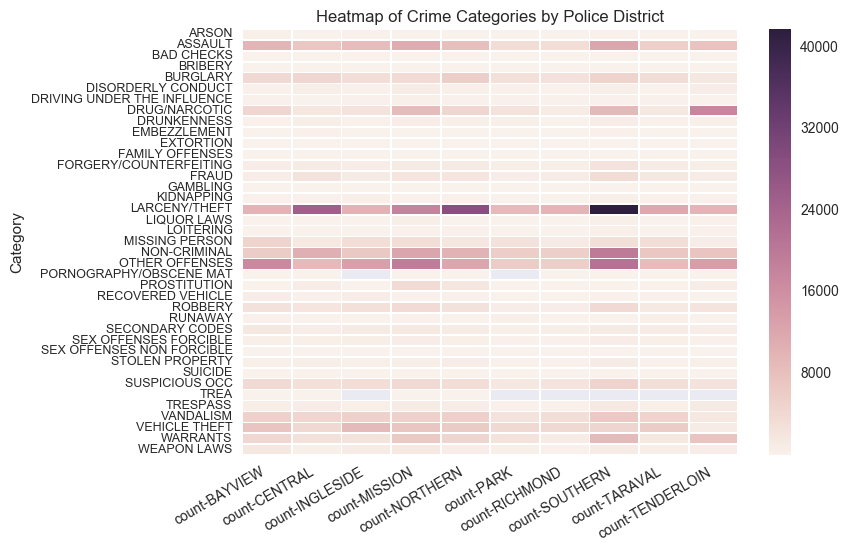

In [6]:
# flights_long = sns.load_dataset("flights")
# flights = flights_long.pivot("month", "year", "passengers")

pdf_long = sfc_train.select("Category","PdDistrict").groupBy("Category","PdDistrict").count().orderBy("count", ascending=False).toPandas()
pdf = pdf_long.pivot("Category","PdDistrict")

# Draw a heatmap with the numeric values in each cell
ax = sns.heatmap(pdf, annot=False, linewidths=.5)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(9)
for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
ax.set(xlabel="", title="Heatmap of Crime Categories by Police District")
sns.plt.show()
# This heat map clearly shows a relationship between the Larceny/Theft category and the Southern Police District


## Step 1:  Establish and evaluate a baseline 

From the profiling results, the most frequent category of crime by far is "LARCENY/THEFT".  We can set our baseline prediction to assume every crime is LARCENY/THEFT regardless of the actual category or any of the other attributes.  Then, evaluate how accurate our baseline preditions are.  Later, we will compare how much better/worse the machine learning methods are compared to this baseline.

For now, we're going to start with Precision-Recall for our evaluation framework.  Later, we may consider additional evaluation metrics (e.g. AUC).

In [7]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="Category", outputCol="indexedLabel").fit(sfc_train)
sfc_train_t = labelIndexer.transform(sfc_train)
# sfc_train_t = sfc_train_t.cache()

baseline_preds = sfc_train_t.selectExpr('indexedLabel as prediction', 'double(0) as label')
baseline_preds = baseline_preds.cache()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction') 
evaluator.evaluate(baseline_preds) 
print ('Precision: {:08.6f}'.format(evaluator.evaluate(baseline_preds, {evaluator.metricName: 'weightedPrecision'})))
print ('Recall:  {:08.6f}'.format(evaluator.evaluate(baseline_preds, {evaluator.metricName: 'weightedRecall'})))
print ('Accuracy:  {:08.6f}'.format(evaluator.evaluate(baseline_preds, {evaluator.metricName: 'accuracy'})))


Precision: 1.000000
Recall:  0.199192
Accuracy:  0.199192


In [8]:
baseline_preds = sfc_train_t.selectExpr('indexedLabel as prediction', 'double(0) as label')
sfc_train_t.show(10)


+--------------------+--------------+--------------------+---------+----------+--------------+--------------------+-----------+---------+------------+
|               Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|          X|        Y|indexedLabel|
+--------------------+--------------+--------------------+---------+----------+--------------+--------------------+-----------+---------+------------+
|2015-05-13 23:53:...|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST| -122.42589|37.774597|         7.0|
|2015-05-13 23:53:...|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST| -122.42589|37.774597|         1.0|
|2015-05-13 23:33:...|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...| -122.42436|37.800415|         1.0|
|2015-05-13 23:30:...| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHERN|          NONE|

### Thus, our machine learning results must be better than guessing that every category is LARCENY/THEFT.


## Step 2:  Prepare the features
The machine learning algorithms can't learn directly from text-based data.  All text based data must be converted to integers or floats.



### Encoding the categorical features ...

In [9]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

cols = ['Descript','DayOfWeek','PdDistrict','Resolution','Address']

for col in cols:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col+'Index')
    model = stringIndexer.fit(sfc_train)
    sfc_train = model.transform(sfc_train)
    encoder = OneHotEncoder(dropLast=False, inputCol=col+'Index', outputCol=col+'Vec')
    sfc_train = encoder.transform(sfc_train)

print("Row count of training set: {:,}".format(sfc_train.count()))
sfc_train.printSchema()


Row count of training set: 878,049
root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: float (nullable = true)
 |-- Y: float (nullable = true)
 |-- DescriptIndex: double (nullable = true)
 |-- DescriptVec: vector (nullable = true)
 |-- DayOfWeekIndex: double (nullable = true)
 |-- DayOfWeekVec: vector (nullable = true)
 |-- PdDistrictIndex: double (nullable = true)
 |-- PdDistrictVec: vector (nullable = true)
 |-- ResolutionIndex: double (nullable = true)
 |-- ResolutionVec: vector (nullable = true)
 |-- AddressIndex: double (nullable = true)
 |-- AddressVec: vector (nullable = true)



In [10]:
sfc_train.select('Descript','DescriptIndex','DescriptVec').show(10,truncate=False)


+------------------------------+-------------+----------------+
|Descript                      |DescriptIndex|DescriptVec     |
+------------------------------+-------------+----------------+
|WARRANT ARREST                |5.0          |(879,[5],[1.0]) |
|TRAFFIC VIOLATION ARREST      |44.0         |(879,[44],[1.0])|
|TRAFFIC VIOLATION ARREST      |44.0         |(879,[44],[1.0])|
|GRAND THEFT FROM LOCKED AUTO  |0.0          |(879,[0],[1.0]) |
|GRAND THEFT FROM LOCKED AUTO  |0.0          |(879,[0],[1.0]) |
|GRAND THEFT FROM UNLOCKED AUTO|53.0         |(879,[53],[1.0])|
|STOLEN AUTOMOBILE             |3.0          |(879,[3],[1.0]) |
|STOLEN AUTOMOBILE             |3.0          |(879,[3],[1.0]) |
|GRAND THEFT FROM LOCKED AUTO  |0.0          |(879,[0],[1.0]) |
|GRAND THEFT FROM LOCKED AUTO  |0.0          |(879,[0],[1.0]) |
+------------------------------+-------------+----------------+
only showing top 10 rows



### What do we do about the "Dates" datetime column ?  ...


Since we know from the data profiling results that the time span of the data is over 12 years, let's start with converting the Dates column to an ordinal (an integer value representing the number of days since year 1 day 1) and including with the VectorAssembler.  After that we'll try transforming the datetime value to year, month, day, day of month, hour of day, season, etc.  DayOfWeek is already provided separately in the dataset.

In [11]:
import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import *

udfDateToordinal = udf(lambda dt: round(dt.timestamp()), IntegerType())
sfc_train = sfc_train.withColumn('Dates_int',udfDateToordinal(sfc_train.Dates))
sfc_train.select('Dates','Dates_int').show(10, truncate=False)

+---------------------+----------+
|Dates                |Dates_int |
+---------------------+----------+
|2015-05-13 23:53:00.0|1431575580|
|2015-05-13 23:53:00.0|1431575580|
|2015-05-13 23:33:00.0|1431574380|
|2015-05-13 23:30:00.0|1431574200|
|2015-05-13 23:30:00.0|1431574200|
|2015-05-13 23:30:00.0|1431574200|
|2015-05-13 23:30:00.0|1431574200|
|2015-05-13 23:30:00.0|1431574200|
|2015-05-13 23:00:00.0|1431572400|
|2015-05-13 23:00:00.0|1431572400|
+---------------------+----------+
only showing top 10 rows



### Assembling the feature vector ...

In [12]:
# Use the VectorAssembler to combine the converted Dates column with the ...
# Vectorized categorical column and also with the lat, long columns
vector_cols = ['Dates_int'] + [name for name,type in sfc_train.dtypes if 'Vec' in name ] + ['X','Y']
assembler = VectorAssembler(inputCols=vector_cols, outputCol="features")
sfc_train = assembler.transform(sfc_train)
sfc_train.select('Category','features').show(5,truncate=False)


+--------------+--------------------------------------------------------------------------------------------------------------------+
|Category      |features                                                                                                            |
+--------------+--------------------------------------------------------------------------------------------------------------------+
|WARRANTS      |(24144,[0,6,881,889,898,4905,24142,24143],[1.43157558E9,1.0,1.0,1.0,1.0,1.0,-122.42588806152344,37.77459716796875]) |
|OTHER OFFENSES|(24144,[0,45,881,889,898,4905,24142,24143],[1.43157558E9,1.0,1.0,1.0,1.0,1.0,-122.42588806152344,37.77459716796875])|
|OTHER OFFENSES|(24144,[0,45,881,889,898,8695,24142,24143],[1.43157438E9,1.0,1.0,1.0,1.0,1.0,-122.42436218261719,37.8004150390625]) |
|LARCENY/THEFT |(24144,[0,1,881,889,897,1845,24142,24143],[1.4315742E9,1.0,1.0,1.0,1.0,1.0,-122.42699432373047,37.800872802734375]) |
|LARCENY/THEFT |(24144,[0,1,881,895,897,4286,24142,24143],[1.4

In [13]:
# trim down to just the columns we need then cache the dataframe, this will help to
# keep the size of thw working dataset more manageable
sfc_train_trimmed = sfc_train.select('Category','features')
sfc_train_trimmed = sfc_train_trimmed.cache()

# write the trimmed DF out to disk, then read it back in
preppedFileName = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/prepped.pqt'
sfc_train_trimmed.write.parquet(preppedFileName, mode='overwrite')

In [14]:
# null out all our dataframes
preppedFileName = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/prepped.pqt'
# preppedFileName = 's3n://caserta-bucket1/lab/SanFranCrime/prepped.pqt/'
sfc_train = None
predictions = None
model = None
encoder = None
baseline_preds = None
sqlContext.clearCache()

prepped = sqlContext.read.parquet(preppedFileName)
print("Row count for prepped dataframe: {:,}".format(prepped.count()))
prepped.printSchema()
prepped = prepped.cache()


Row count for prepped dataframe: 878,049
root
 |-- Category: string (nullable = true)
 |-- features: vector (nullable = true)



## Step 3:  Create train and tune sets and fit a model

### ToDo:  revise the splitting approach to be temporally aware

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
if "indexedLabel" not in prepped.columns:
    labelIndexer = StringIndexer(inputCol="Category", outputCol="indexedLabel").fit(prepped)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = prepped.randomSplit([0.7, 0.3])

# Train a GBT model.
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='features', 
                            # numTrees=30, 
                            numTrees=3, 
                            maxDepth=5,
                            featureSubsetStrategy='auto')

# Chain indexers and RF in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, rf])

# Train model.  This also runs the indexers.
print("Starting the model training ...")
model = pipeline.fit(trainingData)
print("Done with training the model.")

# Make predictions - returns a DataFrame
predictions = model.transform(testData)
predictions.printSchema()

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)
predictions = predictions.cache()

Starting the model training ...
Done with training the model.
root
 |-- Category: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- indexedLabel: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|        27.0|(24144,[0,179,880...|
|       0.0|        27.0|(24144,[0,179,880...|
|       0.0|        27.0|(24144,[0,179,880...|
|       0.0|        27.0|(24144,[0,179,880...|
|       0.0|        27.0|(24144,[0,179,880...|
+----------+------------+--------------------+
only showing top 5 rows



In [16]:
predictions = predictions.cache()
# predictions.select("prediction", "indexedLabel", "features").show(10)
predictions.select("prediction").groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       8.0|   858|
|       0.0|238273|
|       7.0|  8107|
|       1.0|    78|
|      23.0|   503|
|      11.0|    99|
|       3.0|   177|
|       2.0|  4317|
|       6.0|     7|
|       5.0|  8785|
|      15.0|   206|
|      12.0|  2733|
+----------+------+



In [17]:
eval_preds = predictions.select('prediction','indexedLabel')
eval_preds = eval_preds.cache()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='indexedLabel') 
evaluator.evaluate(eval_preds) 
print('Precision: {:08.6f}'.format(evaluator.evaluate(eval_preds, {evaluator.metricName: 'weightedPrecision'})))
print('Recall:  {:08.6f}'.format(evaluator.evaluate(eval_preds, {evaluator.metricName: 'weightedRecall'})))
print('Accuracy:  {:08.6f}'.format(evaluator.evaluate(eval_preds, {evaluator.metricName: 'accuracy'})))

Precision: 0.632192
Recall:  0.295889
Accuracy:  0.295889


## Step 4.  Improve Accuracy through Parameter Tuning, Feature Selection/Engineering, and Experimentation

1. Parameter Tuning:  Cross-Validation
1. Feature Selection/Engineering:  obtain more influential and predictive features through feature engineering or joining with exogenous data sets